## Neural networks for segmentation

In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

!pip install Pillow==4.1.1

!wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
!unzip -q data.zip

tcmalloc: large alloc 1073750016 bytes == 0x5846e000 @  0x7f6fabb7b2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 5.7MB 6.7MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
--2018-11-08 15:12:18--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2018-11-08 15:12:19--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.d

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

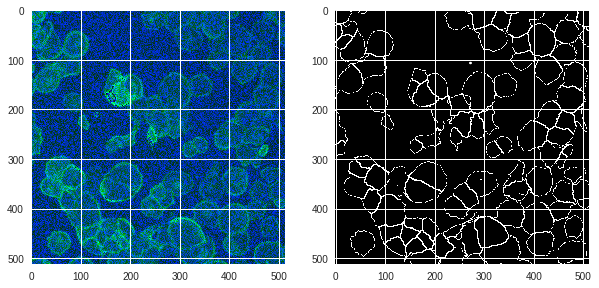

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
use_cuda, torch.version.cuda, torch.__version__

(True, '9.2.148', '0.4.1')

In [0]:
import os
import random

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PairedDataset(Dataset):
    def __init__(self, images_path, segmented_path, image_transforms=None, segmented_transforms=None, images_suffix='-actin.DIB.bmp', segmented_suffix='-cells.png'):
        images_names = os.listdir(images_path)
        self.names = list(map(lambda x: self.get_prefix(x, images_suffix), images_names))
        images = map(lambda x: Image.open(os.path.join(images_path, x)), images_names)
        segmented = map(lambda x: Image.open(os.path.join(segmented_path, x + segmented_suffix)), self.names)
        self.dataset = list(zip(images, segmented))
        self.transforms = list(zip(image_transforms if image_transforms else [], segmented_transforms if segmented_transforms else []))
    
    def get_prefix(self, image_name, images_suffix):
        if images_suffix not in image_name:
            raise ValueError(f'Invalid image name: {image_name}')
        return image_name[:image_name.index(images_suffix)]
    
    def __getitem__(self, index):
        image, segmented = self.dataset[index]
        for image_transform, segmented_transform in self.transforms:
            random_state = random.getstate()
            np_random_state = np.random.get_state()
            image = image_transform(image)
            
            random.setstate(random_state)
            np.random.set_state(np_random_state)
            segmented = segmented_transform(segmented)

        return np.array(image/255, dtype=np.float32), np.array(segmented > 0, dtype=np.uint8)

    def __len__(self):
        return len(self.dataset) 

Для аугментации данных используется небольшое изменение яркости и контраста, повороты в пределах 30 градусов, вертикальные и горизонтальные перевороты. Также попытался использовать RandomResizedCrop, который сначала вырезает кусок картинки, а потом ресайзит до исходного размера, однако, отказался от этой идеи, так как качество получалось хуже (возможно, из-за того, что outline'ы при ресайзе становятся слишком большими)

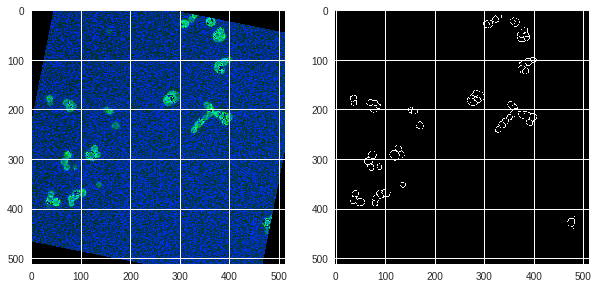

In [64]:
image_transforms = [
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomResizedCrop(size=512),
    transforms.Lambda(np.asarray)
]

segmented_transforms = [transforms.Lambda(lambda x: x)] + image_transforms[1:]

train_dataset = PairedDataset('BBBC018_v1_images-fixed/train', 'BBBC018_v1_outlines/train', image_transforms, segmented_transforms)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
im, mask = train_dataset[0]
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(np.array(mask), 'gray')

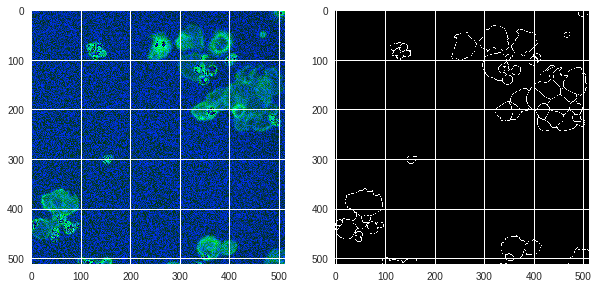

In [65]:
transforms = [transforms.Lambda(np.asarray)]
val_dataset = PairedDataset('BBBC018_v1_images-fixed/val', 'BBBC018_v1_outlines/val', transforms, transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
im, mask = val_dataset[0]
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(np.array(mask), 'gray')

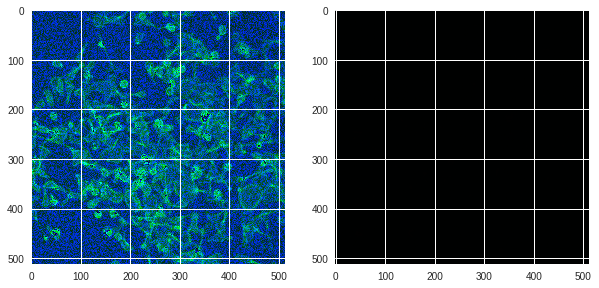

In [66]:
test_dataset = PairedDataset('BBBC018_v1_images-fixed/test', 'BBBC018_v1_images-fixed/test', transforms, transforms, segmented_suffix='-actin.DIB.bmp')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
im, mask = test_dataset[0]
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(np.array(mask), 'gray')

В качестве модели попробовал использовать Fully Convolutional net с семинара, однако данная сеть училась очень долго и медленно. Чтобы ускорить процесс, попробовал менять сверточный слой с самым большим количеством выходных каналов (`conv4_1`, изначально `out_channels=512`). Пробовал сокращать количество каналов до 256 (сходимость не улучшилась) и 64 (сходимость улучшилась, но недостаточно). В конце концов выпилил этот слой, без него сеть достигает необходимого качества и достаточно быстро обучается.

In [0]:
def create_fully_conv_network():
    net = nn.Sequential()
    net.add_module('conv1_1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1));
    net.add_module('bn1_1', nn.BatchNorm2d(num_features=32))
    net.add_module('relu1_1', nn.ReLU(inplace=True))

    net.add_module('conv1_2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1))
    net.add_module('bn1_2', nn.BatchNorm2d(num_features=32))
    net.add_module('relu1_2', nn.ReLU(inplace=True))
    
    net.add_module('mp1', nn.MaxPool2d(kernel_size=3, stride=1, padding=1))

    net.add_module('conv2_1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, dilation=2, padding=2))
    net.add_module('bn2_1', nn.BatchNorm2d(num_features=64))
    net.add_module('relu2_1', nn.ReLU(inplace=True))
    
    net.add_module('conv2_2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, dilation=2, padding=2))
    net.add_module('bn2_2', nn.BatchNorm2d(num_features=64))
    net.add_module('relu2_2', nn.ReLU(inplace=True))
    
    net.add_module('pad2', nn.ConstantPad2d(2, 0))
    net.add_module('mp2', nn.MaxPool2d(kernel_size=3, stride=1, dilation=2, padding=0))

    net.add_module('conv3_1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, dilation=4, padding=4))
    net.add_module('bn3_1', nn.BatchNorm2d(num_features=128))
    net.add_module('relu3_1', nn.ReLU(inplace=True))
    
    net.add_module('conv3_2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, dilation=4, padding=4))
    net.add_module('bn3_2', nn.BatchNorm2d(num_features=128))
    net.add_module('relu3_2', nn.ReLU(inplace=True))
    
    net.add_module('pad3', nn.ConstantPad2d(4, 0))
    net.add_module('mp3', nn.MaxPool2d(kernel_size=3, stride=1, dilation=4, padding=0))
    
    # net.add_module('conv4_1', nn.Conv2d(in_channels=128, out_channels=64, kernel_size=9, dilation=8, padding=32))
    # net.add_module('bn4_1', nn.BatchNorm2d(num_features=64))
    # net.add_module('relu4_1', nn.ReLU(inplace=True))
    
    net.add_module('conv5_1', nn.Conv2d(in_channels=128, out_channels=2, kernel_size=1, dilation=1, padding=0))
    return net

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [0]:
def after_each_epoch_fn(*args, **kwargs):
    epoch_i = kwargs['epoch_i']
    n_epoch = kwargs['n_epoch']
    start = kwargs['epoch_start']
    end = kwargs['epoch_end']
    iou = kwargs['epoch_iou']
    print(f'\rEpoch #{epoch_i + 1}/{n_epoch} ({get_batch_string(*args, **kwargs)}), epoch_iou: {iou:.3f}, epoch_time: {(end - start)/60:.3f} min')

def after_each_batch_fn(*args, **kwargs):
    epoch_i = kwargs['epoch_i']
    n_epoch = kwargs['n_epoch']
    print(f'\rEpoch #{epoch_i + 1}/{n_epoch} ({get_batch_string(*args, **kwargs)})', end='')

def get_batch_string(*args, **kwargs):
    batch_i = kwargs['batch_i']
    n_batch = kwargs['n_batch']
    start = kwargs['batch_start']
    end = kwargs['batch_end']
    loss = kwargs['batch_loss']
    return f'batch #{batch_i + 1}/{n_batch}, batch_loss: {loss:.5f}, batch_time: {end - start:.3f} s'

Обучим нашу модель с использование Early stopping'а и сохранением лучшей модели. Используем threshold=0.8 (в дальнейшем подберем лучше) и веса классов 1 и 10 для "нулевого класса" и границы соответственно

In [0]:
import time

def train(name, model, opt, train_loader, val_loader, threshold=0.8, num_epochs=100, early_stop_after=10, save_best=True):
    train_loss_means = []
    val_iou_means = []
    callback_params = {'n_epoch': num_epochs, 'n_batch': len(train_loader)}
    for epoch in range(num_epochs):
        callback_params['epoch_i'] = epoch
        callback_params['epoch_start'] = time.time()
        model.train(True)
        train_loss = []
        for i, (X_batch, y_batch) in enumerate(train_loader):
            callback_params['batch_i'] = i
            callback_params['batch_start'] = time.time()
            X_batch = Variable(X_batch.permute(0, 3, 1, 2))
            if use_cuda:
                X_batch = X_batch.cuda()
            
            y_batch = Variable(y_batch)
            if use_cuda:
                y_batch = y_batch.cuda()
            
            logits = model(X_batch).permute(0, 2, 3, 1).view(-1, 2)
            
            weight = torch.Tensor([1.0, 10.0])
            if use_cuda:
                weight = weight.cuda()
            
            loss = F.cross_entropy(logits, y_batch.view(-1).long(), weight)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.mean().data[0].cpu().numpy())
            
            callback_params['batch_end'] = time.time()
            callback_params['batch_loss'] = train_loss[-1]
            
            after_each_batch_fn(**callback_params)

        model.train(False)
        val_iou = []
        for X_batch, y_batch in val_loader:
            X_batch = Variable(torch.FloatTensor(X_batch.permute(0, 3, 1, 2)))
            if use_cuda:
                X_batch = X_batch.cuda()
            
            y_batch = Variable(y_batch)
            if use_cuda:
                y_batch = y_batch.cuda()
            
            logits = model(X_batch)
            probs = F.softmax(logits, dim=1)
            mask = probs[:, 1, ...] >= threshold
            val_iou.append(calc_iou(mask.data.cpu().numpy(), y_batch.data.cpu().numpy()))
        
        train_loss_means.append(np.mean(train_loss))
        val_iou_means.append(np.mean(val_iou))
        
        local_max = np.max(val_iou_means)
        
        if save_best and val_iou_means[-1] == local_max:
            torch.save(model.state_dict(), name)
        
        callback_params['epoch_end'] = time.time()
        callback_params['epoch_iou'] = val_iou_means[-1]
        
        after_each_epoch_fn(**callback_params)
        
        if len(val_iou_means) > early_stop_after and local_max not in val_iou_means[-early_stop_after:]:
            print(f'\nEarly stopped after epoch #{epoch + 1}')
            break
    print(f'Best validation accuracy: {np.max(val_iou_means):.4f}' + (f', best model saved to "{name}"' if save_best else ''))
    
    plt.title(name)
    plt.xlabel('n_epoch')
    plt.ylabel('iou')
    plt.plot(list(range(1, len(val_iou_means) + 1)), val_iou_means)
    plt.show()

In [0]:
# use_cuda = False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch #1/100 (batch #41/41, batch_loss: 0.21565, batch_time: 0.541 s), epoch_iou: 0.000, epoch_time: 0.408 min
Epoch #2/100 (batch #41/41, batch_loss: 0.33935, batch_time: 0.563 s), epoch_iou: 0.000, epoch_time: 0.406 min
Epoch #3/100 (batch #41/41, batch_loss: 0.20477, batch_time: 0.549 s), epoch_iou: 0.001, epoch_time: 0.406 min
Epoch #4/100 (batch #41/41, batch_loss: 0.05641, batch_time: 0.564 s), epoch_iou: 0.048, epoch_time: 0.407 min
Epoch #5/100 (batch #41/41, batch_loss: 0.35580, batch_time: 0.540 s), epoch_iou: 0.079, epoch_time: 0.407 min
Epoch #6/100 (batch #41/41, batch_loss: 0.25597, batch_time: 0.548 s), epoch_iou: 0.182, epoch_time: 0.407 min
Epoch #7/100 (batch #41/41, batch_loss: 0.11156, batch_time: 0.566 s), epoch_iou: 0.147, epoch_time: 0.407 min
Epoch #8/100 (batch #41/41, batch_loss: 0.34432, batch_time: 0.554 s), epoch_iou: 0.055, epoch_time: 0.408 min
Epoch #9/100 (batch #41/41, batch_loss: 0.34665, batch_time: 0.553 s), epoch_iou: 0.170, epoch_time: 0.407 min
E

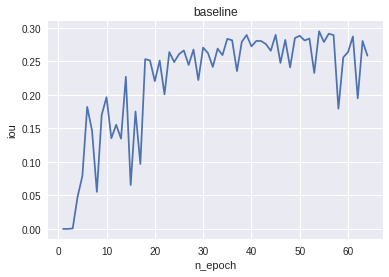

In [48]:
model = create_fully_conv_network()
if use_cuda:
    model = model.cuda()

train('baseline', model, torch.optim.Adam(model.parameters()), train_loader, val_loader)

Несмотря на то, что сработал Early stopping, мы еще можем попробовать дообучить модель с дальнейшим увеличением качества. Возьмем лучшую сохраненную модель с предыдущей итерации и попробуем снова с уменьшеным вдвое шагом:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch #1/100 (batch #41/41, batch_loss: 0.08316, batch_time: 0.552 s), epoch_iou: 0.271, epoch_time: 0.408 min
Epoch #2/100 (batch #41/41, batch_loss: 0.28445, batch_time: 0.564 s), epoch_iou: 0.289, epoch_time: 0.406 min
Epoch #3/100 (batch #41/41, batch_loss: 0.27070, batch_time: 0.553 s), epoch_iou: 0.269, epoch_time: 0.407 min
Epoch #4/100 (batch #41/41, batch_loss: 0.07278, batch_time: 0.565 s), epoch_iou: 0.282, epoch_time: 0.407 min
Epoch #5/100 (batch #41/41, batch_loss: 0.43447, batch_time: 0.551 s), epoch_iou: 0.274, epoch_time: 0.407 min
Epoch #6/100 (batch #41/41, batch_loss: 0.34793, batch_time: 0.559 s), epoch_iou: 0.243, epoch_time: 0.406 min
Epoch #7/100 (batch #41/41, batch_loss: 0.23743, batch_time: 0.548 s), epoch_iou: 0.270, epoch_time: 0.407 min
Epoch #8/100 (batch #41/41, batch_loss: 0.13889, batch_time: 0.560 s), epoch_iou: 0.281, epoch_time: 0.407 min
Epoch #9/100 (batch #41/41, batch_loss: 0.12892, batch_time: 0.550 s), epoch_iou: 0.297, epoch_time: 0.407 min
E

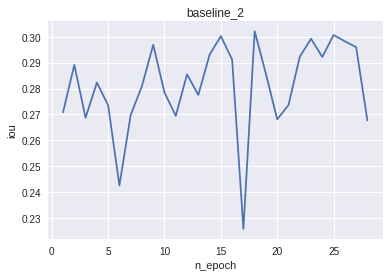

In [49]:
model.load_state_dict(torch.load('baseline'))
train('baseline_2', model, torch.optim.Adam(model.parameters(), lr=5e-4), train_loader, val_loader)

In [0]:
model.load_state_dict(torch.load('baseline_2'))

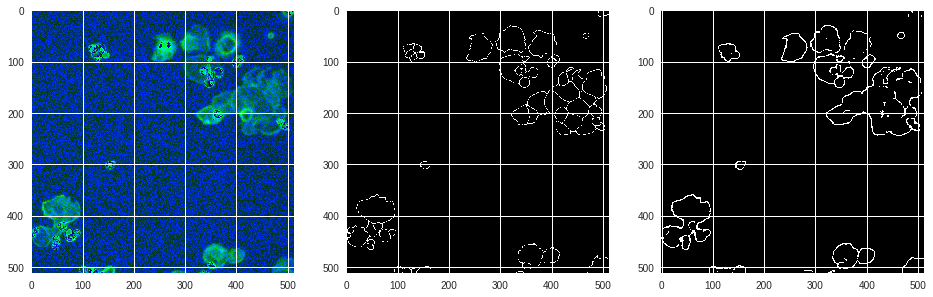

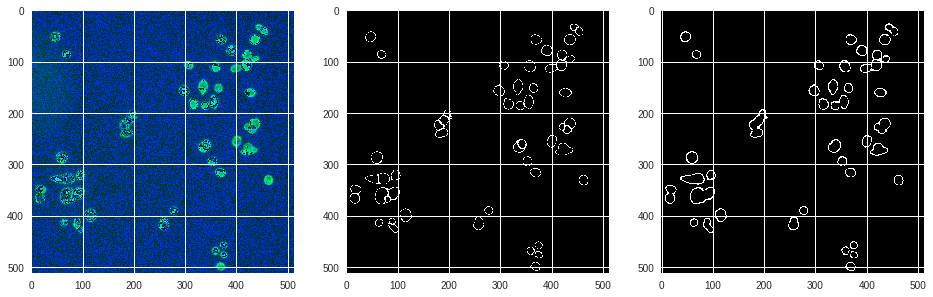

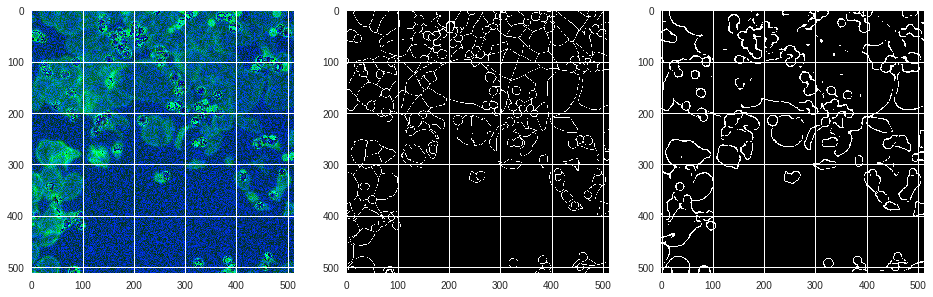

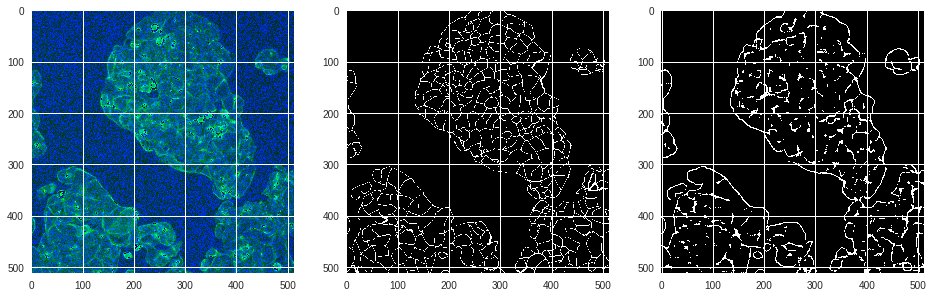

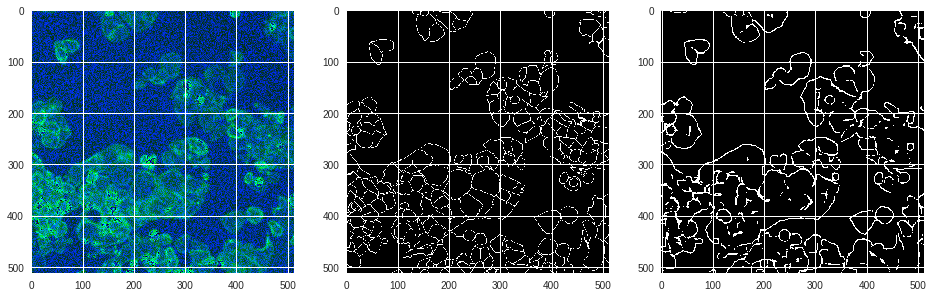

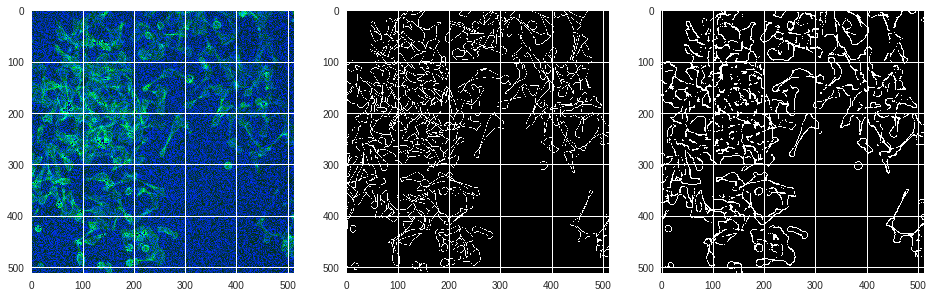

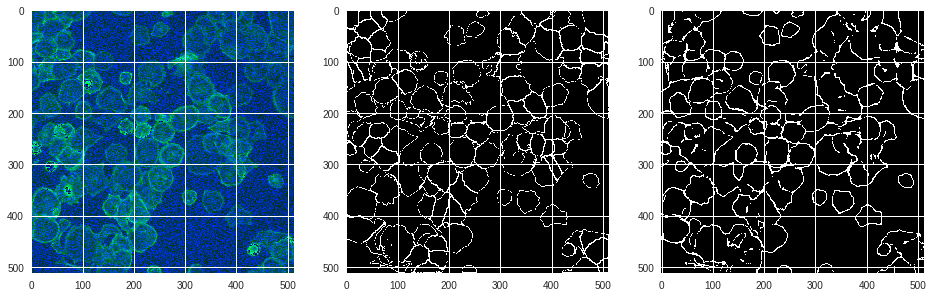

In [52]:
for i, (X_batch, y_batch) in enumerate(val_loader):
    X_batch_var = Variable(X_batch.permute(0, 3, 1, 2))
    if use_cuda:
        X_batch_var = X_batch_var.cuda()
    
    logits = model(X_batch_var)
    probs = F.softmax(logits, dim=1)
    mask = probs[:, 1, ...] < 0.8
    mask = (mask.data.cpu().numpy()[0] * 255).astype(np.uint8)
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,3,1)
    plt.imshow(X_batch[0])
    plt.subplot(1,3,2)
    plt.imshow(np.array(y_batch[0]), 'gray')
    plt.subplot(1,3,3)
    plt.imshow(mask)
    plt.show()

Подберем наилучший threshold

In [53]:
for threshold in [0.6, 0.7, 0.73, 0.75, 0.76, 0.77, 0.78, 0.79, 0.82, 0.9]:
    val_iou = []
    for i, (X_batch, y_batch) in enumerate(val_loader):
        X_batch = Variable(torch.FloatTensor(X_batch.permute(0, 3, 1, 2)))
        if use_cuda:
            X_batch = X_batch.cuda()

        y_batch = Variable(y_batch)
        if use_cuda:
            y_batch = y_batch.cuda()

        logits = model(X_batch)
        probs = F.softmax(logits, dim=1)
        mask = probs[:, 1, ...] >= threshold
        val_iou.append(calc_iou(mask.data.cpu().numpy(), y_batch.data.cpu().numpy()))
    print(threshold, np.mean(val_iou))

0.6 0.28101014839916816
0.7 0.3013411672344114
0.73 0.3053915003903686
0.75 0.3067932768659065
0.76 0.3069823885390255
0.77 0.3064148624743509
0.78 0.30572594604568265
0.79 0.3045237167136268
0.82 0.2943737938508983
0.9 0.17609698590296693


In [0]:
!mkdir result

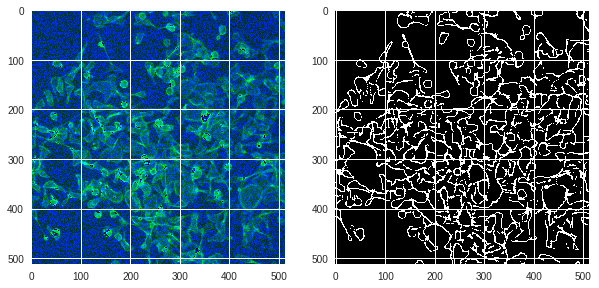

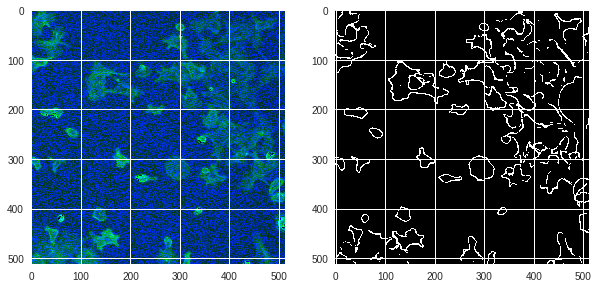

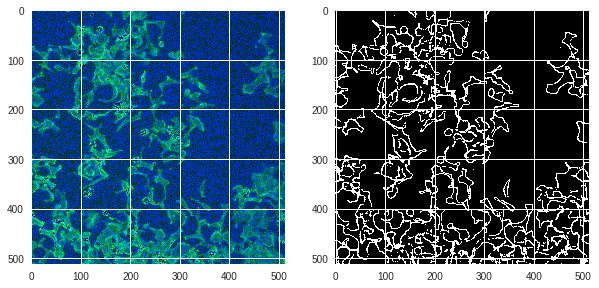

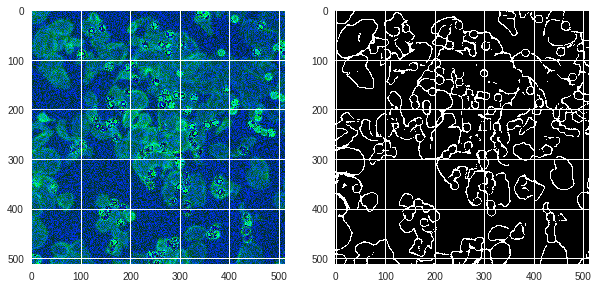

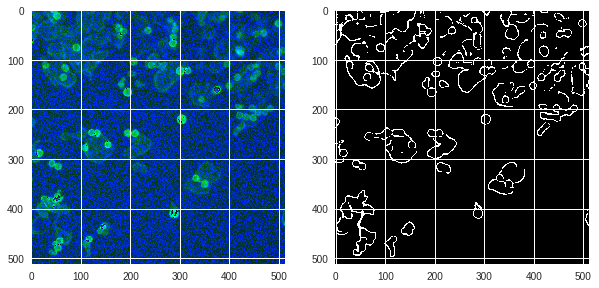

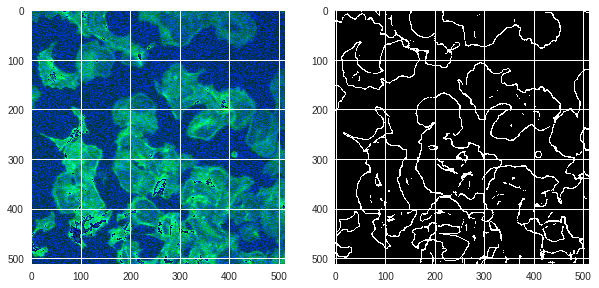

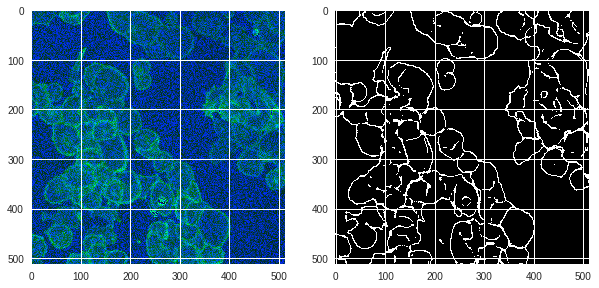

In [67]:
for i, (X_batch, _) in enumerate(test_loader):
    X_batch_var = Variable(X_batch.permute(0, 3, 1, 2))
    if use_cuda:
        X_batch_var = X_batch_var.cuda()
    
    logits = model(X_batch_var)
    probs = F.softmax(logits, dim=1)
    mask = probs[:, 1, ...] < 0.76
    mask = (mask.data.cpu().numpy()[0] * 255).astype(np.uint8)
    
    name = test_dataset.names[i]
    
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(X_batch[0])
    plt.subplot(1,2,2)
    plt.imsave(f'result/{name}-cells.png', mask)
    plt.imshow(mask)
    plt.show()

In [69]:
!zip -r result.zip result/

  adding: result/ (stored 0%)
  adding: result/10780-cells.png (deflated 1%)
  adding: result/13361-cells.png (deflated 0%)
  adding: result/00733-cells.png (deflated 0%)
  adding: result/05624-cells.png (deflated 0%)
  adding: result/19466-cells.png (deflated 0%)
  adding: result/13569-cells.png (deflated 1%)
  adding: result/05899-cells.png (deflated 0%)


In [0]:
from google.colab import files

files.download('baseline_2')
files.download('result.zip') 